In [1]:
# GOAL of the Capstone Project: Build a model to improve the zillow Zestimate residual error (also know as the log-error)
#(i.e “Zestimates” are estimated home values based).

#Source: The dataset was acquired from Kaggle. Two files were provided, one is related to the property
#features and the other file (i.e training file) contains the log-error, which is the output variable. 

#Description: In this competition, Zillow is asking you to build a model that will predict the 
#zillow Zestimate residual error (aka as log-error) given all the property features of a home.
#The log error is defined as logerror=log(Zestimate)−log(SalePrice)and it is recorded in the 
#transactions file train.csv.

#Approach: 1. Load the data
#           2. clean and explore data (i.e correlations or histograms)
#           3. split data into training and testing set
#           4. run the data againts 4 models to determine the 
#               algorithm that will produce the best log error.


In [58]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import seaborn as sns #to visualization
import matplotlib.pyplot as plt # to plot the graphs
import matplotlib.gridspec as gridspec # to do the grid of plots
import warnings # us to hide warning related to parameter defaults and data type conversions
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline


In [59]:
#The Zillow file is a big file and creates slow performance on my machine 
#therefore, I need to a function that will reduce the size of the file by addressing the NaN
#values and converting columns to integers or converting the size of the integer datatype
#to a smaller datatype. 

In [60]:
#define a procedure to reduce the file size by identifying and changing the data types of 
#each of the fields to intergers. The function will also identify the columns with missing values
#and populate values for them.

def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.int8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.int16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.int32)
                    else:
                        props[col] = props[col].astype(np.int64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",props[col].dtype)
            print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist

In [61]:
#Load the properties files that contain our features and the training file
#that contain our outcome variable logerror
df_zhs = pd.read_csv('properties_2017.csv')
train = pd.read_csv('train_2017.csv')

In [62]:
#call the function to reduce the file size, print the before and after data types of 
#each integer field that we change. Also print the columns that were identified as having 
#missing values and populate the values.

df_zhs, NAlist = reduce_mem_usage(df_zhs)
print("_________________")
print("")
print("Warning: the following columns have missing values filled with 'df['column_name'].min() -1': ")
print("_________________")
print("")
print(NAlist)

Memory usage of properties dataframe is : 1320.9731750488281  MB
******************************
Column:  parcelid
dtype before:  int64
dtype after:  int32
******************************
******************************
Column:  airconditioningtypeid
dtype before:  float64
dtype after:  int8
******************************
******************************
Column:  architecturalstyletypeid
dtype before:  float64
dtype after:  int8
******************************
******************************
Column:  basementsqft
dtype before:  float64
dtype after:  int16
******************************
******************************
Column:  bathroomcnt
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  bedroomcnt
dtype before:  float64
dtype after:  int8
******************************
******************************
Column:  buildingclasstypeid
dtype before:  float64
dtype after:  int8
******************************
*****************************

In [11]:
#view the dataframe to see the columns and values for the first 5 rows
df_zhs.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,0,1,19,0.0,0,0,0,0.0,65,...,0,NaN,0,9,2016,9,-0.760000,NaN,-1,-2
1,10759547,0,1,19,0.0,0,0,0,0.0,65,...,0,NaN,0,27516,2015,27516,-0.760000,NaN,-1,-2
2,10843547,0,1,19,0.0,0,5,0,0.0,65,...,1,NaN,660680,1434941,2016,774261,20800.369141,NaN,-1,-2
3,10859147,0,1,19,0.0,0,3,6,0.0,65,...,1,NaN,580059,1174475,2016,594416,14557.570312,NaN,-1,-2
4,10879947,0,1,19,0.0,0,4,0,0.0,65,...,1,NaN,196751,440101,2016,243350,5725.169922,NaN,-1,-2


In [12]:
#view the dataframe to see the columns and values for the first 5 rows
train.head()

,parcelid,logerror,transactiondate
0,14297519,0.025595,2017-01-01
1,17052889,0.055619,2017-01-01
2,14186244,0.005383,2017-01-01
3,12177905,-0.103410,2017-01-01
4,10887214,0.006940,2017-01-01


In [13]:
#view the number of rows and columns of the dataframe
df_zhs.shape

(2985217, 58)

In [14]:
#view the number of rows and columns of the dataframe
train.shape

(77613, 3)

In [15]:
#shows the remaining colums with missing values only
missing_val_count_by_column = (df_zhs.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

hashottuborspa               2935155
propertycountylandusecode       2999
propertyzoningdesc           1002746
fireplaceflag                2980054
taxdelinquencyflag           2928702
dtype: int64


In [16]:
#verify the remaining null columns are of type object
# generic syntax to grab all columns not equal to type object
X_data=df_zhs.dtypes[df_zhs.dtypes=='object'].index
X_data

Index(['hashottuborspa', 'propertycountylandusecode', 'propertyzoningdesc',
       'fireplaceflag', 'taxdelinquencyflag'],
      dtype='object')

In [17]:
#investigate the unques values of column to determine the type of data it should be filed with
df_zhs['hashottuborspa'].value_counts(dropna=False)

NaN     2935155
True      50062
Name: hashottuborspa, dtype: int64

In [18]:
#investigate the unques values of column to determine the type of data it should be filed with
df_zhs['fireplaceflag'].value_counts(dropna=False)

NaN     2980054
True       5163
Name: fireplaceflag, dtype: int64

In [19]:
#investigate the unques values of column to determine the type of data it should be filed with
df_zhs['taxdelinquencyflag'].value_counts(dropna=False)

NaN    2928702
Y        56515
Name: taxdelinquencyflag, dtype: int64

In [20]:
#based on the above I would convert the column to a int by converting the true 
#values into 1 and NaN's into 0 and then performing a dtype conversion on the column.

#use get_dummies to turn the categorical values into integers
df_zhs['hashottuborspaflag'] = pd.get_dummies(df_zhs['hashottuborspa'],dtype=int)
df_zhs['fireplaceflagNF'] = pd.get_dummies(df_zhs['fireplaceflag'],dtype=int)
df_zhs['taxdelinquencyflagNF'] = pd.get_dummies(df_zhs['taxdelinquencyflag'],dtype=int)

In [21]:
#verify the new field has been converted to a numerical column
df_zhs['hashottuborspaflag'].value_counts(dropna=False)

0    2935155
1      50062
Name: hashottuborspaflag, dtype: int64

In [22]:
#verify the new field has been converted to a numerical column
df_zhs['fireplaceflagNF'].value_counts(dropna=False)

0    2980054
1       5163
Name: fireplaceflagNF, dtype: int64

In [23]:
#verify the new field has been converted to a numerical column
df_zhs['taxdelinquencyflagNF'].value_counts(dropna=False)

0    2928702
1      56515
Name: taxdelinquencyflagNF, dtype: int64

In [24]:
#verify the new fields have been added to the data frame
df_zhs.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,hashottuborspaflag,fireplaceflagNF,taxdelinquencyflagNF
0,10754147,0,1,19,0.0,0,0,0,0.0,65,...,9,2016,9,-0.760000,NaN,-1,-2,0,0,0
1,10759547,0,1,19,0.0,0,0,0,0.0,65,...,27516,2015,27516,-0.760000,NaN,-1,-2,0,0,0
2,10843547,0,1,19,0.0,0,5,0,0.0,65,...,1434941,2016,774261,20800.369141,NaN,-1,-2,0,0,0
3,10859147,0,1,19,0.0,0,3,6,0.0,65,...,1174475,2016,594416,14557.570312,NaN,-1,-2,0,0,0
4,10879947,0,1,19,0.0,0,4,0,0.0,65,...,440101,2016,243350,5725.169922,NaN,-1,-2,0,0,0


In [25]:
#merge the training and properties file by parcelid to ensure the model is calculating values found in each file
df_train = df_zhs.merge(train, how='inner', on='parcelid')

In [26]:
#let's see how many rows and columns we have after the merger. Before we had (2985217, 58)
df_train.shape

(77613, 63)

In [27]:
#Check again to see if there are any missing values
missing_val_count_by_column = (df_train.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

hashottuborspa               76074
propertycountylandusecode       34
propertyzoningdesc           27137
fireplaceflag                77441
taxdelinquencyflag           74713
dtype: int64


In [28]:
#view the new data frame and validate the newly merge columns are in the dataframe
df_train.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,hashottuborspaflag,fireplaceflagNF,taxdelinquencyflagNF,logerror,transactiondate
0,17054981,0,1,19,5.0,4,0,0,5.0,65,...,370922,9673.459961,NaN,-1,61110009011034,0,0,0,-0.013099,2017-06-15
1,17055743,0,1,19,2.0,3,0,0,2.0,66,...,305312,5538.799805,NaN,-1,61110009034011,0,0,0,0.073985,2017-07-26
2,17068109,0,1,19,1.5,3,0,0,1.5,66,...,93193,2987.360107,NaN,-1,61110012061086,0,0,0,0.071886,2017-07-28
3,17073952,0,1,19,2.0,2,0,0,2.0,65,...,168531,2706.239990,NaN,-1,61110022003001,0,0,0,0.305680,2017-06-02
4,17078502,0,1,19,1.0,2,0,0,1.0,65,...,444178,6220.700195,NaN,-1,61110019002015,0,0,0,-0.073787,2017-07-07


In [29]:
#Now let's remove from our x_train predictor variable the columns with data types equal to objects
X = df_train.drop(['parcelid', 'logerror', 'transactiondate', 'propertyzoningdesc', 
                         'propertycountylandusecode','hashottuborspa','fireplaceflag','taxdelinquencyflag'], axis=1)
#x_train = np.asarray(x_train)
#create our y_train outcome variable 
y = df_train[['logerror']]

print(X.shape, y.shape)
#train_columns = x_train.columns

(77613, 55) (77613, 1)


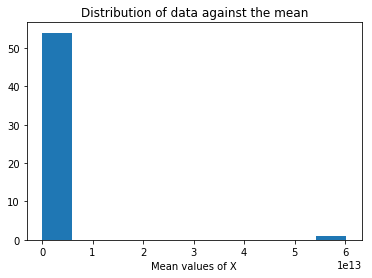

In [30]:
#Determine if your data is normailized, based on the historgram the data is slightly 
#skewed and shows outliers in the data
plt.hist(X.mean(axis=0))
plt.xlabel('Mean values of X')
plt.title('Distribution of data against the mean')
plt.show()

In [31]:
X.mean(axis=0)

airconditioningtypeid           5.838326e-01
architecturalstyletypeid        1.017033e+00
basementsqft                    1.942565e+01
bathroomcnt                     2.297051e+00
bedroomcnt                      3.051448e+00
buildingclasstypeid             7.601819e-04
buildingqualitytypeid           4.193125e+00
calculatedbathnbr               2.296993e+00
decktypeid                      6.500791e+01
finishedfloor1squarefeet        1.062649e+02
calculatedfinishedsquarefeet    1.779531e+03
finishedsquarefeet12            1.676594e+03
finishedsquarefeet13            1.196871e+02
finishedsquarefeet15            1.984988e+02
finishedsquarefeet50            1.092935e+02
finishedsquarefeet6             1.257802e+02
fips                            6.048809e+03
fireplacecnt                    1.272210e-01
fullbathcnt                     2.231263e+00
garagecarcnt                   -7.430456e-02
garagetotalsqft                 1.144281e+02
heatingorsystemtypeid           2.504799e+00
latitude  

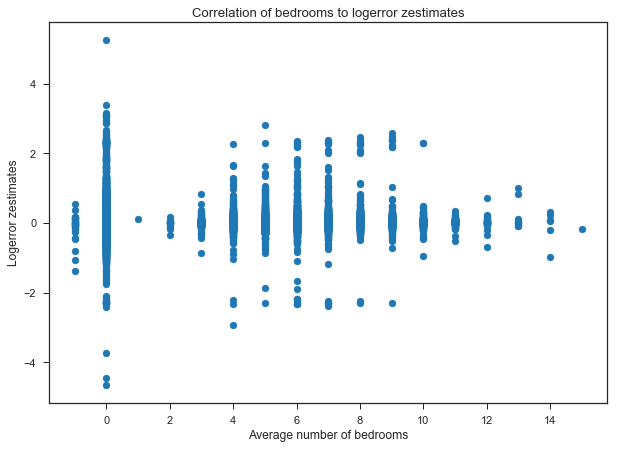

In [38]:
#Let's take a 
plt.figure(figsize=(10,7))
#plt.scatter(X['calculatedbathnbr'], y)
plt.scatter(X['roomcnt'], y)
plt.xlabel('Average number of bedrooms')
plt.ylabel('Logerror zestimates')
plt.title('Correlation of bedrooms to logerror zestimates')
plt.show()

In [39]:
#set aside 20% of the data as a test set for evaluating our model. 
#set an arbitrary "random state" (a.k.a. seed) so that we can reproduce our results.
#good practice to stratify your sample by the target variable. This will ensure our 
#training set looks similar to your test set, making your evaluation metrics more reliable

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y.values.ravel(), 
                                                    test_size=0.2, 
                                                    random_state=123)


In [49]:
#Many algorithms assume that all features are centered around zero and have approximately 
#the same variance. Standardizing the our features helps to accomplish the goal of 
#centering the data around zero. Based on plot above we see that we have outliers in our data 
#so utilizing the standardscaler function will ensure we address the outliers before running
#our model.

#import warnings
#warnings.filterwarnings("ignore")

#  Declare data preprocessing steps
pipeline = make_pipeline(preprocessing.StandardScaler(), 
                         linear_model.Ridge())
 
#  Declare hyperparameters to tune
hyperparameters = { 'ridge__alpha' : [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6]}
 
#  Tune model using cross-validation pipeline
clf = GridSearchCV(pipeline, hyperparameters, cv=3,return_train_score=True )
 
clf.fit(X_train, y_train)
 
#  Refit on the entire training set
# No additional code needed if clf.refit == True (default is True)
 
#  Evaluate model pipeline on test data
pred = clf.predict(X_test)

ridge_r2_score = r2_score(y_test,pred)
mse = mean_squared_error(y_test,pred)
rmse = np.sqrt(mean_squared_error(y_test,pred))

# R2 total variance explained by model) / total variance
print("R2 score : %.3f" % ridge_r2_score)
print("Mean squared error: %.3f" % mse)
print('Root Mean squared error: %.3f' % rmse)
print("Best alpha using built-in RidgeCV: %s" % clf.best_params_)
print('CV mean train results:',clf.cv_results_['mean_train_score'].mean())
print('CV mean test results:',clf.cv_results_['mean_test_score'].mean())
print('CV std mean results:',clf.cv_results_['std_train_score'].mean())
print('CV std test results:',clf.cv_results_['std_test_score'].mean())

R2 score : 0.008
Mean squared error: 0.026
Root Mean squared error: 0.161
Best alpha using built-in RidgeCV: {'ridge__alpha': 6}
CV mean train results: 0.007518169093444456
CV mean test results: 0.001034655071040952
CV std mean results: 0.0011297419636709328
CV std test results: 0.00228541875355318


In [50]:
#create a result table
data = [{'Model':'Ridge', 'Best Parameter': clf.best_params_,
        'R2': ridge_r2_score,'MSE': mse, 'RMSE': rmse}]
df_results = pd.DataFrame(data)

df_results


,Best Parameter,MSE,Model,R2,RMSE
0,{'ridge__alpha': 6},0.025897,Ridge,0.007694,0.160924


In [51]:
#import warnings
#warnings.filterwarnings("ignore")

#  Declare data preprocessing steps
pipeline = make_pipeline(preprocessing.StandardScaler(), 
                         linear_model.Lasso())
 
#  Declare hyperparameters to tune
hyperparameters = { 'lasso__alpha' : [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6]}
 
#  Tune model using cross-validation pipeline
clf = GridSearchCV(pipeline, hyperparameters, cv=3 ,return_train_score=True)
 
clf.fit(X_train, y_train)
 
#  Refit on the entire training set
# No additional code needed if clf.refit == True (default is True)
 
#  Evaluate model pipeline on test data
pred = clf.predict(X_test)

lasso_r2_score = r2_score(y_test,pred)
mse = mean_squared_error(y_test,pred)
rmse = np.sqrt(mean_squared_error(y_test,pred))

# R2 total variance explained by model) / total variance
print("R2 score : %.3f" % lasso_r2_score)
print("Mean squared error: %.3f" % mse)
print('Root Mean squared error: %.3f' % rmse)
print("Best alpha using built-in RidgeCV: %s" % clf.best_params_)
print('CV mean train results:',clf.cv_results_['mean_train_score'].mean())
print('CV mean test results:',clf.cv_results_['mean_test_score'].mean())
print('CV std mean results:',clf.cv_results_['std_train_score'].mean())
print('CV std test results:',clf.cv_results_['std_test_score'].mean())

R2 score : -0.000
Mean squared error: 0.026
Root Mean squared error: 0.162
Best alpha using built-in RidgeCV: {'lasso__alpha': 0.01}
CV mean train results: 0.0
CV mean test results: -4.678565768864613e-05
CV std mean results: 0.0
CV std test results: 2.8810395100557862e-05


In [52]:
#update result table
data = [{'Model':'Lasso', 'Best Parameter': clf.best_params_,
        'R2': lasso_r2_score,'MSE': mse, 'RMSE': rmse}]

d2 = pd.DataFrame(data)
df_results = df_results.append(d2) 

df_results

,Best Parameter,MSE,Model,R2,RMSE
0,{'ridge__alpha': 6},0.025897,Ridge,0.007694,0.160924
0,{'lasso__alpha': 0.01},0.026097,Lasso,-0.000003,0.161547


In [38]:
#df_results = df_results.drop(0)
#df_results

In [53]:
# 5. Declare data preprocessing steps
pipeline = make_pipeline(preprocessing.StandardScaler(), 
                         RandomForestRegressor(n_estimators=10))
 
#  Declare hyperparameters to tune
hyperparameters = { 'randomforestregressor__max_features' : ['auto', 'sqrt', 'log2'],
                  'randomforestregressor__max_depth': [None, 5, 3, 1]}
 
#  Tune model using cross-validation pipeline
clf = GridSearchCV(pipeline, hyperparameters, cv=3)
 
clf.fit(X_train, y_train)
 
#  Refit on the entire training set
# No additional code needed if clf.refit == True (default is True)
 
#  Evaluate model pipeline on test data
pred = clf.predict(X_test)

rfr_r2_score = r2_score(y_test,pred)
mse = mean_squared_error(y_test,pred)
rmse = np.sqrt(mean_squared_error(y_test,pred))

print("R2 score : %.3f" % rfr_r2_score)
print("Mean squared error: %.3f" % mse)
print('Root Mean squared error: %.3f' % rmse)
print("Best alpha using built-in RidgeCV: %s" % clf.best_params_)
print('CV mean train results:',clf.cv_results_['mean_train_score'].mean())
print('CV mean test results:',clf.cv_results_['mean_test_score'].mean())
print('CV std mean results:',clf.cv_results_['std_train_score'].mean())
print('CV std test results:',clf.cv_results_['std_test_score'].mean())


R2 score : -0.001
Mean squared error: 0.026
Root Mean squared error: 0.162
Best alpha using built-in RidgeCV: {'randomforestregressor__max_depth': 5, 'randomforestregressor__max_features': 'log2'}
CV mean train results: 0.21234189943779105
CV mean test results: -0.03427817098168808
CV std mean results: 0.003997591768273253
CV std test results: 0.008938260871201554


In [54]:
#update result table
data = [{'Model':'Random Forest', 'Best Parameter': clf.best_params_,
        'R2': rfr_r2_score,'MSE': mse, 'RMSE': rmse}]

d2 = pd.DataFrame(data)
df_results = df_results.append(d2) 

df_results

,Best Parameter,MSE,Model,R2,RMSE
0,{'ridge__alpha': 6},0.025897,Ridge,0.007694,0.160924
0,{'lasso__alpha': 0.01},0.026097,Lasso,-0.000003,0.161547
0,"{'randomforestregressor__max_depth': 5, 'rando...",0.026119,Random Forest,-0.000827,0.161613


In [55]:
#  Declare data preprocessing steps
pipeline = make_pipeline(preprocessing.StandardScaler(), 
                         DecisionTreeRegressor())
 
#  Declare hyperparameters to tune
hyperparameters = { 'decisiontreeregressor__max_features' : ['auto', 'sqrt', 'log2'],
                  'decisiontreeregressor__max_depth': [5, 3, 1, 7, 9]}
 
#  Tune model using cross-validation pipeline
clf = GridSearchCV(pipeline, hyperparameters, cv=3)
 
clf.fit(X_train, y_train)
 
#  Refit on the entire training set
# No additional code needed if clf.refit == True (default is True)
 
#  Evaluate model pipeline on test data
pred = clf.predict(X_test)

dtr_r2_score = r2_score(y_test,pred)
mse = mean_squared_error(y_test,pred)
rmse = np.sqrt(mean_squared_error(y_test,pred))

print("R2 score : %.3f" % dtr_r2_score)
print("Mean squared error: %.3f" % mse)
print('Root Mean squared error: %.3f' % rmse)
print("Best alpha using built-in RidgeCV: %s" % clf.best_params_)
print('CV mean train results:',clf.cv_results_['mean_train_score'].mean())
print('CV mean test results:',clf.cv_results_['mean_test_score'].mean())
print('CV std mean results:',clf.cv_results_['std_train_score'].mean())
print('CV std test results:',clf.cv_results_['std_test_score'].mean())

R2 score : -0.001
Mean squared error: 0.026
Root Mean squared error: 0.162
Best alpha using built-in RidgeCV: {'decisiontreeregressor__max_depth': 1, 'decisiontreeregressor__max_features': 'log2'}
CV mean train results: 0.04309386532092286
CV mean test results: -0.031535567875123634
CV std mean results: 0.006073827706991512
CV std test results: 0.015011956941192929


In [56]:
#update result table
data = [{'Model':'Decision Tree', 'Best Parameter': clf.best_params_,
        'R2': dtr_r2_score,'MSE': mse, 'RMSE': rmse}]

d2 = pd.DataFrame(data)
df_results = df_results.append(d2) 

#rearrange the column names

df_results = df_results[['Model', 'Best Parameter', 'R2', 'MSE', 'RMSE']]

df_results

,Model,Best Parameter,R2,MSE,RMSE
0,Ridge,{'ridge__alpha': 6},0.007694,0.025897,0.160924
0,Lasso,{'lasso__alpha': 0.01},-0.000003,0.026097,0.161547
0,Random Forest,"{'randomforestregressor__max_depth': 5, 'rando...",-0.000827,0.026119,0.161613
0,Decision Tree,"{'decisiontreeregressor__max_depth': 1, 'decis...",-0.001259,0.026130,0.161648


In [57]:
#create a dataframe with the cross validation results of the best parameter
#df_best_parm_results = pd.DataFrame(data=clf.cv_results_)
#print('Shows details of the results for the best parameter choosen for the model:', best_model_name)
#df_best_parm_results.head()